In [78]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime

In [79]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


In [80]:
dut_os = "Win32NT"
profiler_name = "IntelPowerGadget"

dut_name = "PowerKomplett" 
version = 5

dut_name = "Surface4Pro"
version = 8

# dut_name = "SurfaceBook"
# version = 4


test_case_name = "IdleCase"
# test_case_name = "DiningPhilosophers"

min_temp = 0
max_temp = 200

min_battery = 1
max_battery = 100

between = 0
duration = 1


language = "CSharp"
env = "PROD"

limit = 200

In [81]:
energy_profiler = EnergyProfiler(profiler_name, repository)

energy_profiler.id, energy_profiler.energy_profiler_name


(1, 'IntelPowerGadget')

In [82]:
dut = Dut(dut_name, dut_os, repository)

dut.id, dut.dut_name, dut.dut_os

(6, 'Surface4Pro', 'Win32NT')

In [83]:
config = Configuration(min_temp, max_temp, min_battery, max_battery, duration, between, version, repository, env)

config.id, config.min_battery, config.max_battery, config.min_temp, config.max_temp, config.version, config.env, config.duration, config.between

(26, 1, 100, 0, 200, 8, 'PROD', 1, 0)

In [84]:
test_case = TestCase(test_case_name, repository)
test_case.id, test_case.test_case_name

(3, 'IdleCase')

In [85]:
experiment = Experiment(config.id, dut.id, test_case.id, language, repository, 200)
len(experiment.experiments), experiment.config_id, experiment.dut_id, experiment.language, experiment.test_case_id, experiment.count


(14, 26, 6, 'CSharp', 3, 200)

In [86]:
repository.close()

In [87]:
temp_experiment = experiment.experiments[0]

temp_experiment.end_time, temp_experiment.start_time, temp_experiment.runs, temp_experiment.iteration, temp_experiment.duration

(datetime.datetime(2022, 10, 28, 11, 43, 36, 640765),
 datetime.datetime(2022, 10, 28, 11, 42, 36, 495876),
 2,
 14,
 60067)

In [88]:
[x.value for x in temp_experiment.start_temperature.data], [x.value for x in temp_experiment.stop_temperature.data]

([Decimal('39'), Decimal('40')], [Decimal('37'), Decimal('38')])

In [89]:
[x.value for x in temp_experiment.start_battery.data], [x.value for x in temp_experiment.stop_battery.data]

([Decimal('71')], [Decimal('70')])

In [90]:
durations = [x.duration / x.runs for x in experiment.experiments]
dram_avg = [x.CumulativeDramEnergyInJoules for x in experiment.experiments]
gt_power_avg = [x.CumulativeGtEnergyInJoules for x in experiment.experiments]
ai_power_avg = [x.CumulativeIaEnergyInJoules for x in experiment.experiments]
processor_power_avg = [x.CumulativeProcessorEnergyInJoules for x in experiment.experiments]

In [91]:
dram_avg

[29409728,
 29247680,
 29308104,
 29346376,
 29409728,
 29370116,
 30175536,
 29405090,
 29469848,
 29553894,
 30002564,
 29979980,
 30182068,
 32310852]

In [92]:
def add_avg_and_std(values, dict, name, i):
    dict[i]["avg_" + name] = sum(values) / len(values)  
    dict[i]["std_" + name] = np.std(values) 
    dict[i]["len_" + name] = len(values) 

In [93]:
def plot_for_key(values_to_plot, key, y_max):
    plt.ylim(0,y_max)
    x = [v for v in values_to_plot]
    y = [values_to_plot[v]["avg_" + key] for v in values_to_plot]
    e = [values_to_plot[v]["std_" + key] for v in values_to_plot]
    
    counts = [values_to_plot[v]["len_" + key] for v in values_to_plot]
    
    print(f"The count: {counts}")

    plt.errorbar(x, y, e, linestyle='None', marker='.')

In [94]:
groups = defaultdict(list)
values = defaultdict(dict)

for obj in experiment.experiments:
    groups[obj.iteration].append(obj)

tuples_to_plot = []

for g in groups:
    if not g in values:
        values[g] = {}
    
    durations = [x.duration / x.runs for x in groups[g]]
    dram_avg = [x.AverageDramPowerInWatt for x in groups[g]]
    gt_power_avg = [x.CumulativeGtEnergyInMwh for x in groups[g]]
    ai_power_avg = [x.AverageIaPowerInWatt for x in groups[g]]
    processor_power_avg = [x.AverageProcessorPowerWatt for x in groups[g]]
    
    # dram_avg = [x.CumulativeDramEnergyInJoules for x in groups[g]]
    # gt_power_avg = [x.CumulativeGtEnergyInJoules for x in groups[g]]
    # ai_power_avg = [x.CumulativeIaEnergyInJoules for x in groups[g]]
    # processor_power_avg = [x.CumulativeProcessorEnergyInJoules for x in groups[g]]
    
    
    add_avg_and_std(durations, values, "duration", g)
    add_avg_and_std(dram_avg, values, "dram", g)
    add_avg_and_std(gt_power_avg, values, "gt", g)
    add_avg_and_std(ai_power_avg, values, "ai", g)
    add_avg_and_std(processor_power_avg, values, "processor", g)



The count: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


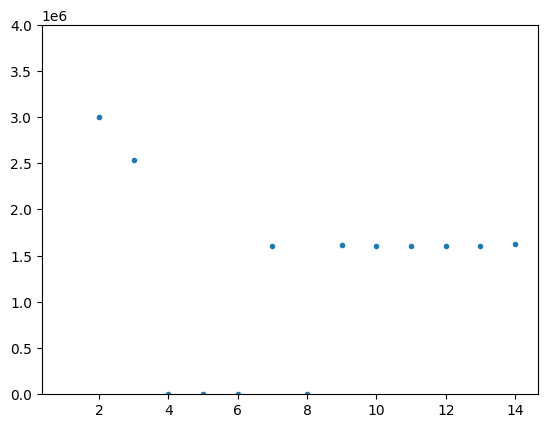

In [95]:
plot_for_key(values, "processor", 4000000)


The count: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


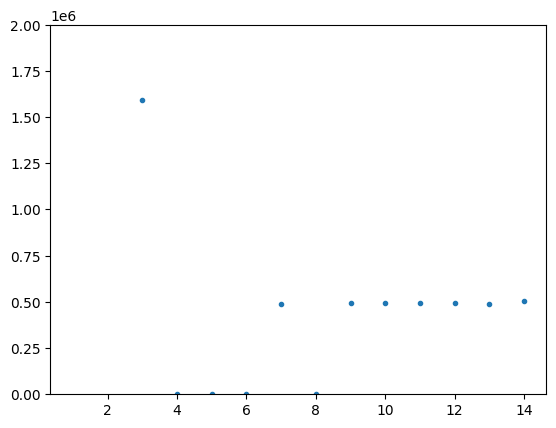

In [96]:
plot_for_key(values, "ai", 2000000)


The count: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


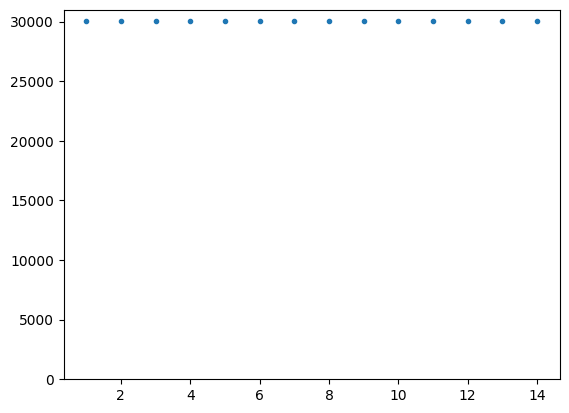

In [97]:
plot_for_key(values, "duration", 31000)

The count: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


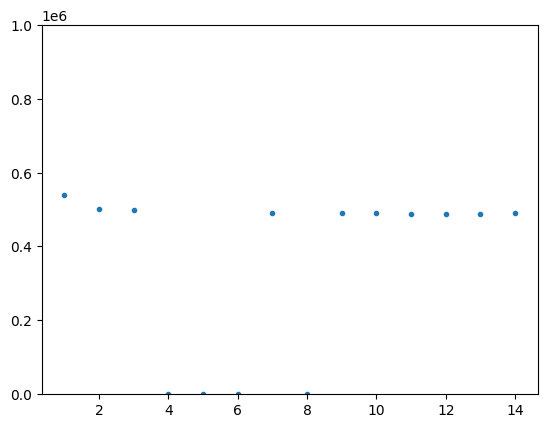

In [98]:
plot_for_key(values, "dram", 1000000)

In [114]:
experiment.experiments[0].time_series.data_point[0].SystemTime, experiment.experiments[0].time_series.data_point[0].PackagePL4_0Watt

('13:42:36:648', '  46.000')

In [119]:
def get_time(data_point):
    return datetime.strptime(data_point.SystemTime, '%H:%M:%S:%f')

def get_y(data_point):
    return float(data_point.DRAMPower_0Watt.strip())

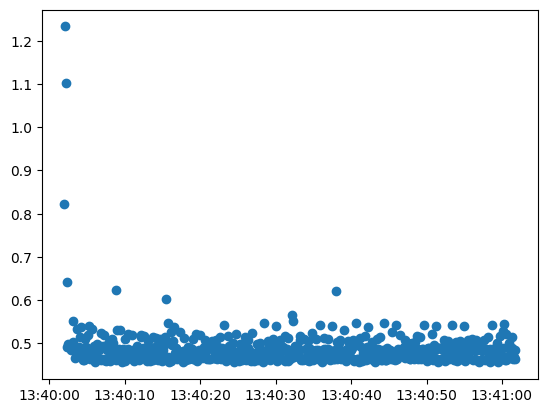

In [120]:
index_to_plot = 2
points_to_plot = -1
experiment_to_plot = experiment.experiments[index_to_plot]

tuples_to_plot = [(get_time(x), get_y(x)) for x in experiment_to_plot.time_series.data_point[:points_to_plot]]

plt.scatter(*zip(*tuples_to_plot))

```json
{
    "SystemTime": "13:26:40:313",
    "RDTSC": " 271802431256",
    "ElapsedTimesec": "   59.225",
    "CPUUtilization": "   43.000",
    "CPUFrequency_0MHz": " 1800",
    "ProcessorPower_0Watt": "   3.571",
    "CumulativeProcessorEnergy_0Joules": " 384.071",
    "CumulativeProcessorEnergy_0mWh": " 106.686",
    "IAPower_0Watt": "   2.073",
    "CumulativeIAEnergy_0Joules": " 323.572",
    "CumulativeIAEnergy_0mWh": "  89.881",
    "PackageTemperature_0C": " 44",
    "PackageHot_0": "  0",
    "DRAMPower_0Watt": "   0.555",
    "CumulativeDRAMEnergy_0Joules": "  31.903",
    "CumulativeDRAMEnergy_0mWh": "   8.862",
    "GTPower_0Watt": "   0.003",
    "CumulativeGTEnergy_0Joules": "   0.568",
    "CumulativeGTEnergy_0mWh": "   0.158",
    "PackagePL1_0Watt": "  25.000",
    "PackagePL2_0Watt": "  25.000",
    "PackagePL4_0Watt": "  46.000",
    "PlatformPsysPL1_0Watt": "  45.000",
    "PlatformPsysPL2_0Watt": "  45.000",
    "GTFrequencyMHz": 0,
    "GTUtilization": "   0.000"
  },
```

In [102]:
# [x.value for x in temp_experiment.battery.data]
min_bucket = 0
max_bucket = 100
bucket_size = 5

last_value = 0

for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
    print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
    last_value = i



min: 0, max: 5, between: 2.5
min: 5, max: 10, between: 7.5
min: 10, max: 15, between: 12.5
min: 15, max: 20, between: 17.5
min: 20, max: 25, between: 22.5
min: 25, max: 30, between: 27.5
min: 30, max: 35, between: 32.5
min: 35, max: 40, between: 37.5
min: 40, max: 45, between: 42.5
min: 45, max: 50, between: 47.5
min: 50, max: 55, between: 52.5
min: 55, max: 60, between: 57.5
min: 60, max: 65, between: 62.5
min: 65, max: 70, between: 67.5
min: 70, max: 75, between: 72.5
min: 75, max: 80, between: 77.5
min: 80, max: 85, between: 82.5
min: 85, max: 90, between: 87.5
min: 90, max: 95, between: 92.5
min: 95, max: 100, between: 97.5
